# Assess quality of latents

## Imports

In [1]:
import h5py
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import random

/home/vafeidis/.conda/envs/behavior/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vafeidis/.conda/envs/behavior/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vafeidis/.conda/envs/behavior/lib/python3.11/site-packages/uma

In [2]:
from ava.data.data_container import DataContainer
from ava.plotting.grid_plot import indexed_grid_plot_DC
import audio_utils.io
from itertools import repeat
from joblib import Parallel, delayed
from ava.preprocessing.utils import get_spec
from ava.models.vae import X_SHAPE, VAE
from ava.preprocessing.preprocess import process_sylls
import torch

In [3]:
%matplotlib inline

## Create data container object

In [4]:
root = '/mnt/labNAS/usv_calls/usv_note_analysis/230118_MZ18_MZ23_1_final_run2'
audio_dirs = [os.path.join(root, 'audio_Cliff')]
seg_dirs = [os.path.join(root, 'segs_Cliff_ex')]
proj_dirs = [os.path.join(root, 'projections_Cliff_ex')]
spec_dirs = [os.path.join(root, 'specs_Cliff_ex')]
model_filename = os.path.join(root, 'checkpoint_050.tar')
plots_dir = root
dc = DataContainer(projection_dirs=proj_dirs, spec_dirs=spec_dirs, plots_dir=plots_dir, model_filename=model_filename)

## Preprocess

In [5]:
params = {
    'preprocess': {
        'get_spec': get_spec,
        'max_dur': 0.2, # maximum syllable duration
        'min_freq': 10e3, # minimum frequency
        'max_freq': 100e3, # maximum frequency
        'num_freq_bins': X_SHAPE[0], # hard-coded
        'num_time_bins': X_SHAPE[1], # hard-coded
        'nperseg': 1024, # FFT
        'noverlap': 512, # FFT
        'spec_min_val': 1.5, # minimum log-spectrogram value
        'spec_noise_thres': 2.5, # if no value in spectogram is above this, co
        'spec_max_val': 4.5, # maximum log-spectrogram value
        'fs': 250000, # audio samplerate
        'mel': False, # frequency spacing, mel or linear
        'time_stretch': False, # stretch short syllables?
        'within_syll_normalize': True, # normalize spectrogram values on a
                                        # spectrogram-by-spectrogram basis
        'normalize_quantile': 0.0, # throw away values below this quantile
        'max_num_syllables': None, # maximum number of syllables per directory
        'sylls_per_file': 1, # syllable per file
        'sigma': 1,
        'flip': False,
        'notch_filter': False, # whether to apply notch filter for 60 kHz noise
        'fn': 54e3, # frequency of notch filter
        'q': 30, # quality factor
        'real_preprocess_params': ('min_freq', 'max_freq', 'spec_min_val', \
                'spec_max_val', 'max_dur'), # tunable parameters
        'int_preprocess_params': ('nperseg','noverlap'), # tunable parameters
        'binary_preprocess_params': ('time_stretch', 'mel', \
                'within_syll_normalize'), # tunable parameters
    },
}

In [8]:
n_jobs = os.cpu_count()-1
gen = zip(audio_dirs, seg_dirs, spec_dirs, repeat(params['preprocess']))
Parallel(n_jobs=n_jobs)(delayed(process_sylls)(*args) for args in gen)

/home/vafeidis/.conda/envs/behavior/lib/python3.11/site-packages/ava/preprocessing/utils.py:65: UserWarning: Found segment longer than max_dur: 0.2709999999997308s, max_dur = 0.2s
  warnings.warn(message)


[None]

In [5]:
onsets = dc.request('onsets')
offsets = dc.request('offsets')
ava_embedding_detections = pd.DataFrame(np.vstack([onsets, offsets]).T, columns=['onsets', 'offsets'])
ava_embedding_detections

Reading field: onsets
	Done with: onsets
Reading field: offsets
	Done with: offsets


,onsets,offsets
0,0.4520,0.4930
1,6.5817,6.6667
2,8.8680,8.9310
3,18.2049,18.2544
4,20.1855,20.2660
...,...,...
1015,4109.1904,4109.2319
1016,4112.2213,4112.2933
1017,4112.4042,4112.4507
1018,4118.8755,4118.9360


In [6]:
usvseg_filepath = '/mnt/labNAS/usv_calls/usv_note_analysis/230118_MZ18_MZ23_1_final_run2/segs_Cliff_ex/Cliffs_annotated_examples.csv'
usvseg_detections = pd.read_csv(usvseg_filepath)
usvseg_detections = usvseg_detections.sort_values('start',ascending=True)
usvseg_detections

,Var1,start,end,duration,maxfreq,maxamp,meanfreq,cvfreq,min,max_fund,max_cand,in_song,detection_side,has_overlap,code,overlap_idx,manual_type,labels
0,1,0.4670,0.4780,11.0,39.035,-70.90,43.612,0.1377,37213.1803,51552.8404,51552.8404,0,left,0.0000,0,NaN,10,6
1,19,6.5967,6.6517,55.0,21.843,-59.09,29.256,0.4412,15924.3036,71481.6517,89987.3636,0,left,0.0000,0,NaN,7,3
2,27,8.8830,8.9160,33.0,31.124,-54.02,33.570,0.1417,30318.9644,50668.0968,97319.0974,0,left,0.0000,0,NaN,7,3
3,53,18.2199,18.2394,19.5,63.412,-63.12,59.733,0.3312,39644.9764,88573.1320,88573.1320,0,left,0.0000,0,NaN,10,6
4,65,20.2005,20.2510,50.5,25.934,-54.07,35.202,0.7950,15677.5543,41954.0228,82702.8766,0,left,0.0000,0,NaN,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,7568,4109.2054,4109.2169,11.5,17.918,-69.96,17.798,0.0066,17494.3976,17951.0178,17951.0178,0,left,0.0000,0,NaN,10,6
1016,14636,4112.2363,4112.2783,42.0,21.684,-68.44,38.923,0.8118,15588.9460,123862.1461,123862.1461,0,left,0.0385,6,5055.0,6,3
1017,14637,4112.4192,4112.4357,16.5,21.560,-69.01,20.366,0.1286,16475.3193,24785.4353,24785.4353,0,left,0.0156,6,5056.0,1,1
1018,14645,4118.8905,4118.9210,30.5,22.943,-72.09,35.253,0.6444,16714.4528,61281.8952,61281.8952,0,left,0.0180,6,5064.0,1,1


In [7]:
for i in range(ava_embedding_detections.shape[0]):
    ava_onset = ava_embedding_detections.iloc[i,0]
    usvseg_onset = usvseg_detections.iloc[i,1]
    if abs(ava_onset+0.015-usvseg_onset)>1e-3:
        print(f'ava detection {i} not matching with usvseg detection {i}')

In [8]:
ava_embedding_detections['label'] = usvseg_detections['labels'].iloc[:ava_embedding_detections.shape[0]].copy()
ava_embedding_detections

,onsets,offsets,label
0,0.4520,0.4930,6
1,6.5817,6.6667,3
2,8.8680,8.9310,3
3,18.2049,18.2544,6
4,20.1855,20.2660,3
...,...,...,...
1015,4109.1904,4109.2319,6
1016,4112.2213,4112.2933,3
1017,4112.4042,4112.4507,1
1018,4118.8755,4118.9360,1


## Embed latent means

In [9]:
latent_means = dc.request('latent_means')

Reading field: latent_means
	Done with: latent_means


## Perform hierarchical clustering

In [10]:
similarity_matrix = cosine_similarity(latent_means)
linkage_matrix = linkage(similarity_matrix, method='complete')

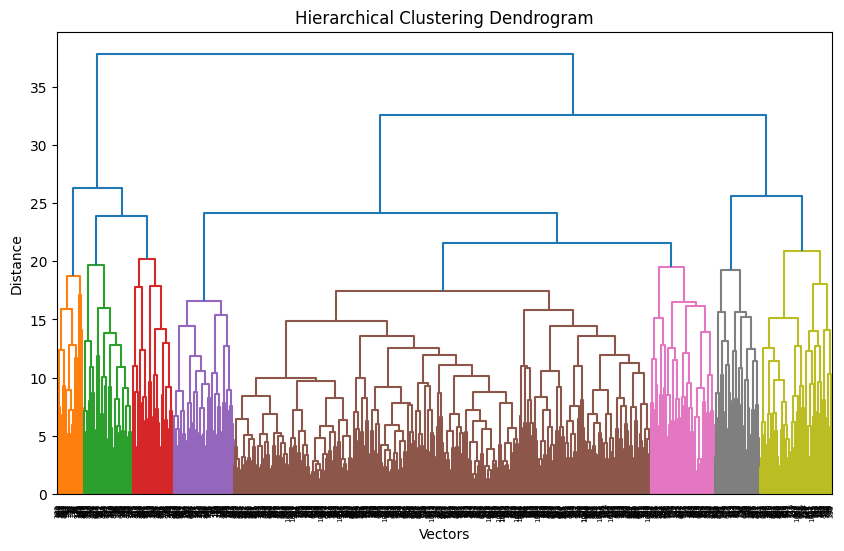

In [11]:
threshold = 21
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix,color_threshold=threshold)
plt.xlabel('Vectors')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

## Compare with Cliff's labels

Text(0.5, 1.0, 'Similarity matrix')

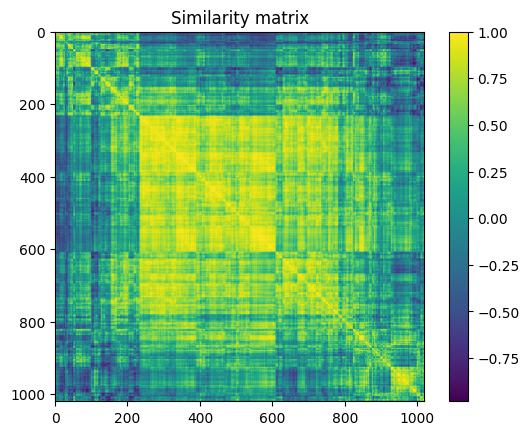

In [12]:
# Get the order of samples in the clustered tree
leaves_list = dendrogram(linkage_matrix, no_plot=True)['leaves']

# Reorder the similarity matrix based on the clustering
reordered_matrix = similarity_matrix[leaves_list][:, leaves_list]

plt.imshow(reordered_matrix)
plt.colorbar()
plt.title('Similarity matrix')

,onsets,offsets,label
509,1706.4433,1706.5157,1
587,2020.2820,2020.3260,1
577,1984.5540,1984.6285,1
576,1977.9056,1977.9506,1
572,1965.3939,1965.4549,1
...,...,...,...
28,86.8202,86.8632,6
318,986.3928,986.4633,6
479,1631.8566,1631.8981,6
727,2544.2220,2544.2655,6


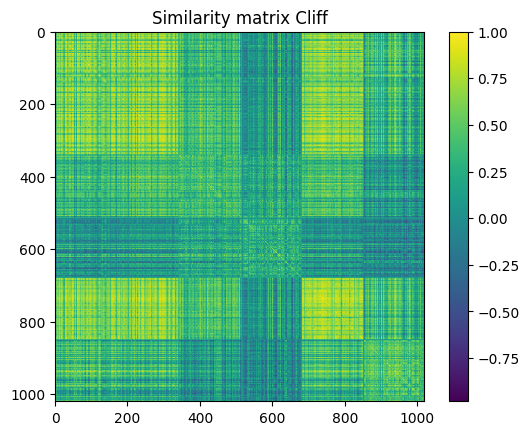

In [13]:
# Reorder based on Cliff's labels
ava_sorted = ava_embedding_detections.sort_values(by='label')
indices = ava_sorted.index

reordered_cliff = similarity_matrix[indices][:, indices]

plt.imshow(reordered_cliff)
plt.colorbar()
plt.title('Similarity matrix Cliff')

ava_sorted

Text(0.5, 1.0, 'Order in recording')

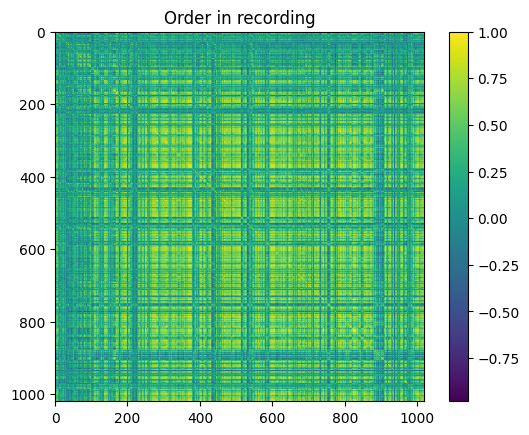

In [14]:
# In order they appear in recording

plt.imshow(similarity_matrix)
plt.colorbar()
plt.title('Order in recording')

## Dimensionality of latents

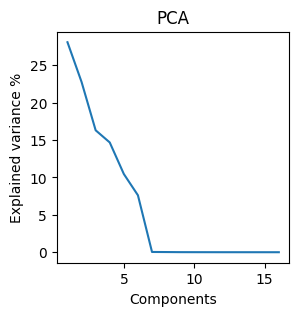

In [15]:
n_comp = 32
show = n_comp//2

# Fit PCA
pca = PCA(n_components=n_comp)
pca.fit(latent_means)

# Access the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(3, 3))
plt.plot(np.arange(1,show+1),100*explained_variance_ratio[:show])
plt.xlabel('Components')
plt.ylabel('Explained variance %')
plt.title('PCA')
plt.show()

## Look at PCs at pixel space

In [16]:
# Define model
model = VAE(save_dir=root)
model.load_state(model_filename)

In [17]:
# Get spectograms from components
components = torch.from_numpy(pca.components_).to('cuda').to(torch.float32)
components_spec = model.decode(components).cpu().detach().numpy().reshape((-1,X_SHAPE[0],X_SHAPE[1]))

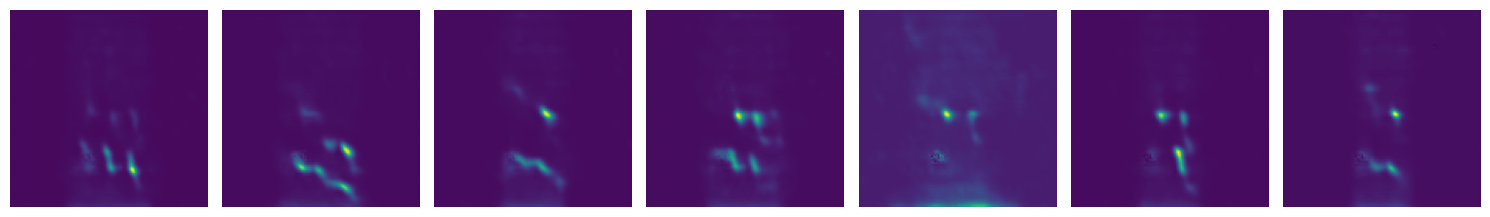

In [18]:
n_plot = 7

# Set up the subplots grid
fig, axes = plt.subplots(1, n_plot, figsize=(15, 3))

# Iterate over the images and plot them
for i, image in enumerate(components_spec[0:n_plot]):
    # Plot the image in the corresponding subplot
    axes[i].imshow(np.flipud(image))
    axes[i].axis('off')  # Turn off the axis labels
    
# Set a common scale for all images
for ax in axes:
    ax.set_aspect('equal')  # Set equal aspect ratio for all subplots
    
# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

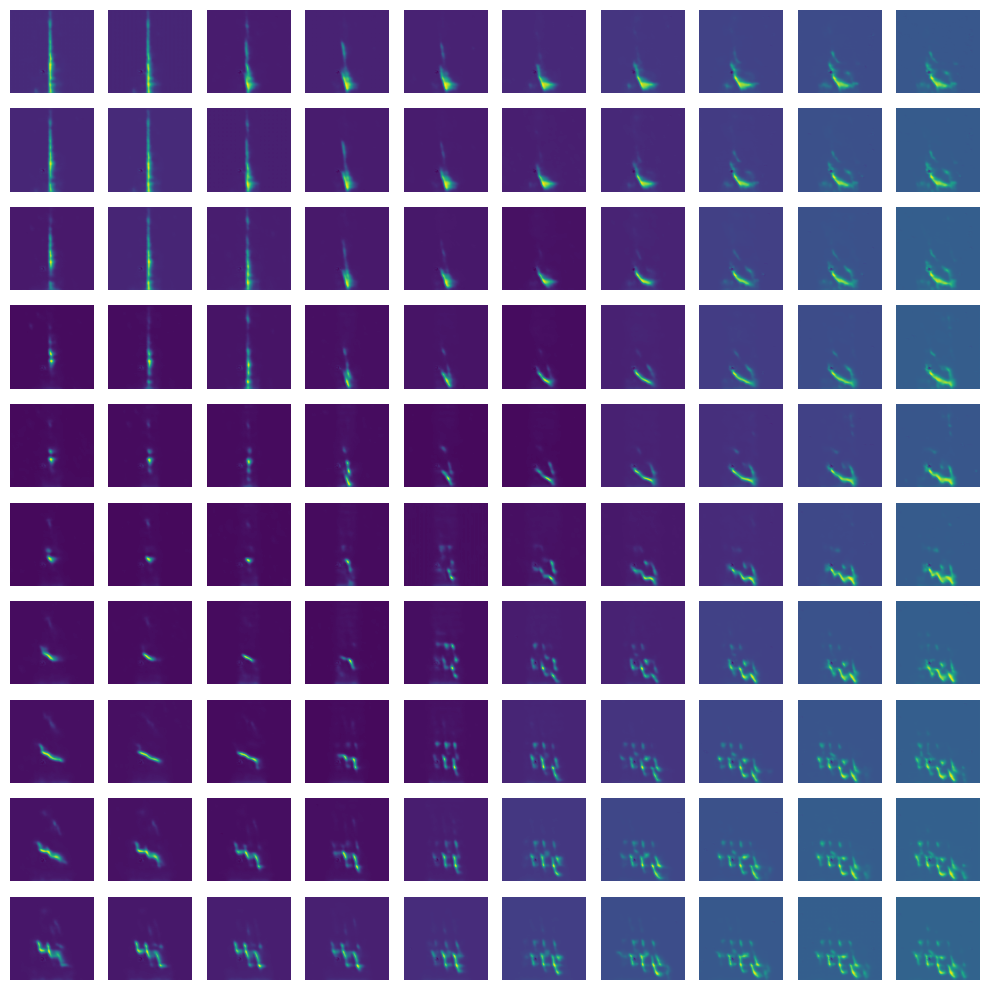

In [30]:
# Sweep space spanned by first 2 PCs

PC1, PC2 = pca.components_[:2]

# Get the minimum and maximum values of PC1 and PC2 from the transformed data
pc1_min, pc1_max = np.min(pca.transform(latent_means)[:, 0]), np.max(pca.transform(latent_means)[:, 0])
pc2_min, pc2_max = np.min(pca.transform(latent_means)[:, 1]), np.max(pca.transform(latent_means)[:, 1])

# Define the ranges for weights corresponding to PC1 and PC2
weight_range_pc1 = np.linspace(pc1_min, pc1_max, 10)
weight_range_pc2 = np.linspace(pc2_min, pc2_max, 10)

# Plot the reconstructions in the 2D grid
plt.figure(figsize=(10, 10))
for i in range(weight_range_pc1.size):
    for j in range(weight_range_pc2.size):
        plt.subplot(weight_range_pc1.size, weight_range_pc2.size, i * weight_range_pc2.size + j + 1)
        combo = pca.mean_ + weight_range_pc1[i]*PC1 + weight_range_pc1[j]*PC2
        combo = torch.from_numpy(combo).to('cuda').to(torch.float32)
        combo_spec = model.decode(combo).cpu().detach().numpy().reshape((X_SHAPE[0],X_SHAPE[1]))
        plt.imshow(np.flipud(combo_spec))
        plt.axis('off')

plt.tight_layout()
plt.show()

## Reconstruct examples with increasing number of PCs

In [24]:
# Select the desired number of PCs for reconstruction
num_pcs = range(1, n_comp + 1)


# Perform reconstruction for each number of PCs
reconstructions = []
for n in num_pcs:
    # Select the top n PCs
    pcs = pca.components_[:n]

    # Calculate the reconstruction matrix
    reconstruction = np.dot(pca.transform(latent_means)[:, :n], pcs)
    reconstruction = torch.from_numpy(reconstruction).to('cuda').to(torch.float32)
    reconstructions.append(model.decode(reconstruction).cpu().detach().numpy().reshape((-1,X_SHAPE[0],X_SHAPE[1])))

reconstructions = np.array(reconstructions)

# original data
original = torch.from_numpy(latent_means).to('cuda').to(torch.float32)
original = model.decode(original).cpu().detach().numpy().reshape((-1,X_SHAPE[0],X_SHAPE[1]))

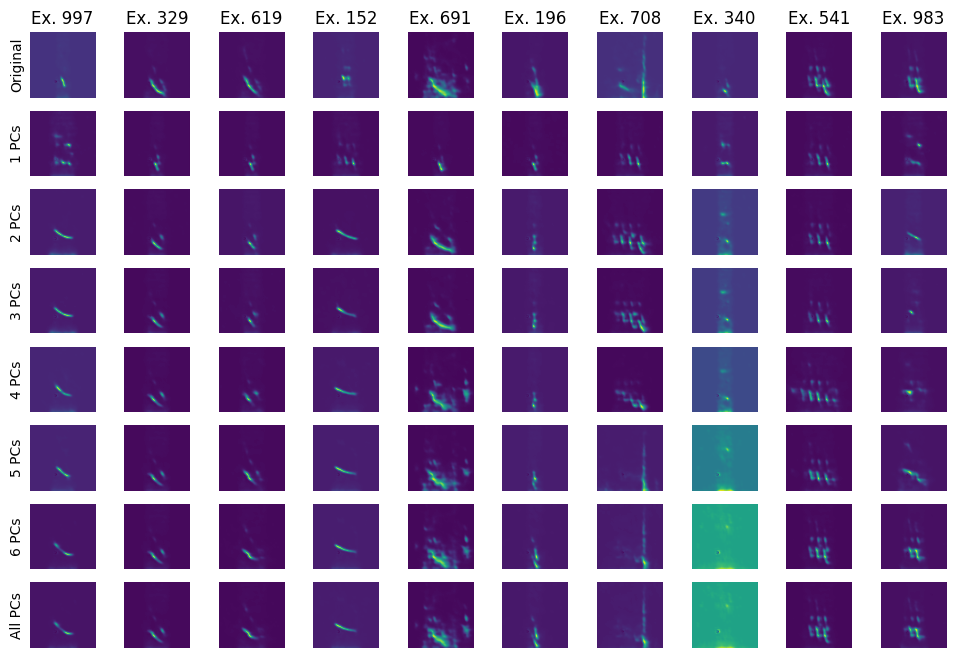

In [25]:
# Set the number of examples to plot in each row
num_examples = 10

# Create the subplots
fig, axs = plt.subplots(n_plot+1, num_examples, figsize=(12, 8))

# Examples to plot
np.random.seed(41)
examples_to_plot = np.random.choice(original.shape[0], size=num_examples, replace=False)

# Plot the original data and the reconstructions
for i in range(num_examples*(n_plot+1)):
    row = i % (n_plot+1)
    col = i // (n_plot+1)

    # Plot the original data
    if row == 0:
        axs[row, col].imshow(np.flipud(original[examples_to_plot[col]]))
        axs[row, col].set_title(f'Ex. {examples_to_plot[col]}')
        if col == 0:
            axs[row, col].set_ylabel('Original')
    
    elif row == n_plot:
        axs[row, col].imshow(np.flipud(reconstructions[-1][examples_to_plot[col]]))
        if col == 0:
            axs[row, col].set_ylabel('All PCs')
    else:
    # Plot the reconstructions using an increasing number of PCs
        axs[row, col].imshow(np.flipud(reconstructions[row-1][examples_to_plot[col]]))
        if col == 0:
            axs[row, col].set_ylabel('{} PCs'.format(row))
        
    axs[row, col].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                              labelbottom=False, labelleft=False)
    
    # Remove the spines (lines surrounding each plot)
    axs[row, col].spines['top'].set_visible(False)
    axs[row, col].spines['bottom'].set_visible(False)
    axs[row, col].spines['left'].set_visible(False)
    axs[row, col].spines['right'].set_visible(False)

# Show the plot
plt.show()

## Try ICA

In [26]:
# Create an instance of the FastICA model
ica = FastICA(n_components=7, random_state=42)

# Fit the model to the data
ica.fit_transform(latent_means)

# Get components
ICA_components = torch.from_numpy(ica.components_).to('cuda').to(torch.float32)
ICA_components_spec = model.decode(ICA_components).cpu().detach().numpy().reshape((-1,X_SHAPE[0],X_SHAPE[1]))

/home/vafeidis/.conda/envs/behavior/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


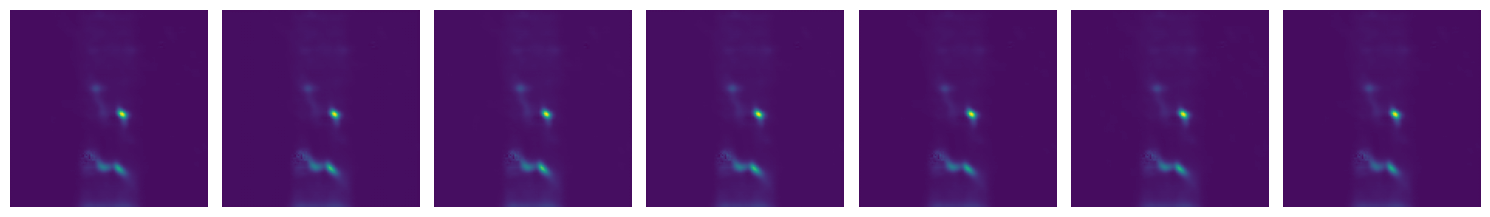

In [27]:
n_plot = 7

# Set up the subplots grid
fig, axes = plt.subplots(1, n_plot, figsize=(15, 3))

# Iterate over the images and plot them
for i, image in enumerate(ICA_components_spec[0:n_plot]):
    # Plot the image in the corresponding subplot
    axes[i].imshow(np.flipud(image))
    axes[i].axis('off')  # Turn off the axis labels
    
# Set a common scale for all images
for ax in axes:
    ax.set_aspect('equal')  # Set equal aspect ratio for all subplots
    
# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Plot several examples from each class

In [28]:
# Assign cluster labels based on the threshold
clusters = fcluster(linkage_matrix, threshold, criterion='distance')

# Create a dictionary to store an index from each assigned class
class_indexes = {}

# Iterate over the cluster labels and store the indexes for each class
for i, cluster_label in enumerate(clusters):
    if cluster_label not in class_indexes:
        class_indexes[cluster_label] = []
    class_indexes[cluster_label].append(i)

# Retrieve the unique class labels in the order they appear in the dendrogram
unique_labels = np.unique(clusters)

In [29]:
np.random.seed(13)

# Set the number of random examples to select from each class
num_examples = 5

# Randomly select examples from each class
random_indexes = {}
for label, indexes in class_indexes.items():
    random_indexes[label] = np.random.choice(indexes, size=num_examples, replace=False)

In [30]:
indices = random_indexes.values()
indexed_grid_plot_DC(dc, np.array(list(random_indexes.values())).T)

Reading field: specs
	Done with: specs


## Sanity check for representation similarity with VAE trained in flipped spectograms

In [56]:
root = '/mnt/labNAS/usv_calls/usv_note_analysis/230118_MZ18_MZ23_1_flipped'
proj_dirs = [os.path.join(root, 'projections_Cliff')]
spec_dirs = [os.path.join(root, 'specs_Cliff')]
model_filename = os.path.join(root, 'checkpoint_010.tar')
plots_dir = root
dcFlip = DataContainer(projection_dirs=proj_dirs, spec_dirs=spec_dirs, plots_dir=plots_dir, model_filename=model_filename)

In [57]:
onsets = dcFlip.request('onsets')
offsets = dcFlip.request('offsets')
ava_embedding_detections = pd.DataFrame(np.vstack([onsets, offsets]).T, columns=['onsets', 'offsets'])
#ava_embedding_detections = ava_embedding_detections.sort_values('onsets',ascending=True)
ava_embedding_detections

Reading field: onsets
	Done with: onsets
Reading field: offsets
	Done with: offsets


,onsets,offsets
0,0.4520,0.4930
1,6.5817,6.6667
2,8.8680,8.9310
3,18.2049,18.2544
4,20.1855,20.2660
...,...,...
1015,4109.1904,4109.2319
1016,4112.2213,4112.2933
1017,4112.4042,4112.4507
1018,4118.8755,4118.9360


In [59]:
latent_means = dcFlip.request('latent_means')

Making field: latent_means
Making field: latent_means
	Done with: latent_means


Text(0.5, 1.0, 'Similarity matrix for flipped network')

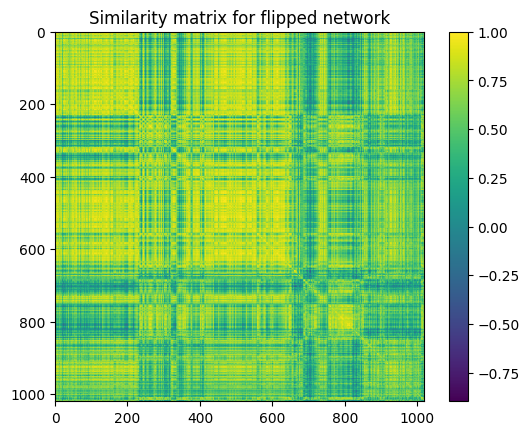

In [61]:
similarity_matrix = cosine_similarity(latent_means)

# Reorder the similarity matrix based on the clustering
reordered_matrix = similarity_matrix[leaves_list][:, leaves_list]

plt.imshow(reordered_matrix)
plt.colorbar()
plt.title('Similarity matrix for flipped network')